In [1]:
%matplotlib inline
import os
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes

In [1]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sf/nuscenes-devkit/python-sdk/data/sets/nuscenes', verbose=False)

In [2]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/sf/nuscenes-devkit/python-sdk/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval ...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 49.7 seconds.
Reverse indexing ...
Done reverse indexing in 9.1 seconds.


1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

## useful stuff

In [31]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

In [13]:
nusc.list_attributes()

cycle.with_rider: 7331
cycle.without_rider: 17345
pedestrian.moving: 157444
pedestrian.sitting_lying_down: 13939
pedestrian.standing: 46530
vehicle.moving: 149203
vehicle.parked: 420226
vehicle.stopped: 65975


In [48]:
nusc.visibility

[{'description': 'visibility of whole object is between 0 and 40%',
  'level': 'v0-40',
  'token': '1'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'level': 'v40-60',
  'token': '2'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'level': 'v60-80',
  'token': '3'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'level': 'v80-100',
  'token': '4'}]

## tokens

In [63]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

{'description': 'visibility of whole object is between 80 and 100%',
 'level': 'v80-100',
 'token': '4'}

### using next

In [21]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

---

In [4]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from matplotlib.axes import Axes
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box

In [5]:
sample_data_token = my_sample['data']['CAM_FRONT']
data_path, boxes, camera_intrinsic = nusc.get_sample_data(sample_data_token, box_vis_level=BoxVisibility.ANY)

NameError: name 'my_sample' is not defined

In [6]:
# global boxes

def get_color(category_name: str) -> Tuple[int, int, int]:
        """ Provides the default colors based on the category names. """
        if category_name in ['vehicle.bicycle', 'vehicle.motorcycle']:
            return 255, 61, 99  # Red
        elif 'vehicle' in category_name:
            return 255, 158, 0  # Orange
        elif 'human.pedestrian' in category_name:
            return 0, 0, 230  # Blue
        elif 'cone' in category_name or 'barrier' in category_name:
            return 0, 0, 0  # Black
        else:
            return 255, 0, 255  # Magenta
        
def render_sample_data(sample_data_token: str,
                           with_anns: bool = True,
                           box_vis_level: BoxVisibility = BoxVisibility.ANY,
                           axes_limit: float = 40,
                           ax: Axes = None,
                           nsweeps: int = 1) -> None:
    # Load boxes and image.
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(sample_data_token,
                                                                   box_vis_level=box_vis_level)
    data = Image.open(data_path)

    # Init axes.
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(9, 16))

    # Show image.
    ax.imshow(data)
    
    # Show boxes.
    if with_anns:
        for box in boxes:
            c = np.array(get_color(box.name)) / 255.0
            box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

    # Limit visible range.
    ax.set_xlim(0, data.size[0])
    ax.set_ylim(data.size[1], 0)

In [7]:
def draw_3D(corners, colors, linewidth):
    # Draw the sides
    for i in range(4):
        axis.plot([corners.T[i][0], corners.T[i + 4][0]],
                  [corners.T[i][1], corners.T[i + 4][1]],
                  color=colors[2], linewidth=linewidth)

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0])
    draw_rect(corners.T[4:], colors[1])

def box_2D(corners):
    # control how much of the width to remove
    width_reduce = 0.14
    xmax = min(corners.T[:,0].max(), 1600)
    xmin = max(corners.T[:,0].min(), 0)
    width = xmax - xmin
    xmax -= (width_reduce/2) * width
    xmin += (width_reduce/2)  *width

    ymax = min(corners.T[:,1].max(), 900)
    ymin = max(corners.T[:,1].min(), 0)
    return xmax, xmin, ymax, ymin

def render_2D(self,
               axis: Axes,
               view: np.ndarray = np.eye(2),
               normalize: bool = False,
               colors: Tuple = ('b', 'r', 'k'),
               linewidth: float = 2):
    global corners
    corners = view_points(self.corners(), view, normalize=normalize)[:2, :]

    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
            prev = corner
    
    xmax, xmin, ymax, ymin = box_2D(corners)
    box2d_corners = [[xmin,ymin],[xmin,ymax],[xmax,ymax],[xmax,ymin]]
    draw_rect(box2d_corners, (0.9,0.5,0.7))

---
## Saving labels in YOLO form
1. filter camera images by presence of **human.pedestrian, vehicle.bicycle, vehicle.motorcycle**
2. filter by visibility (>60?)
3. convert category to yolo classes
4. convert box to 2D
5. combine all annotations in frame
6. save as **image_name.txt**

In [45]:
nusc.list_categories()

Category stats for split v1.0-trainval:
animal                      n=  787, width= 0.37±0.13, len= 0.86±0.36, height= 0.60±0.20, lw_aspect= 2.35±0.69
human.pedestrian.adult      n=208240, width= 0.67±0.13, len= 0.73±0.19, height= 1.77±0.18, lw_aspect= 1.11±0.26
human.pedestrian.child      n= 2066, width= 0.51±0.14, len= 0.53±0.15, height= 1.38±0.25, lw_aspect= 1.05±0.23
human.pedestrian.constructi n= 9161, width= 0.72±0.20, len= 0.71±0.20, height= 1.74±0.30, lw_aspect= 1.02±0.29
human.pedestrian.personal_m n=  395, width= 0.62±0.12, len= 1.18±0.31, height= 1.71±0.27, lw_aspect= 1.98±0.64
human.pedestrian.police_off n=  727, width= 0.73±0.14, len= 0.69±0.13, height= 1.83±0.14, lw_aspect= 0.97±0.18
human.pedestrian.stroller   n= 1072, width= 0.63±0.13, len= 0.95±0.27, height= 1.17±0.15, lw_aspect= 1.58±0.68
human.pedestrian.wheelchair n=  503, width= 0.77±0.10, len= 1.09±0.23, height= 1.37±0.09, lw_aspect= 1.42±0.23
movable_object.barrier      n=152087, width= 2.53±0.64, len= 0.50±0.17,

In [8]:
from tqdm import tqdm
yolo_classes= ['person','bicycle','car','motorbike','bus','truck']
relevant_classes = ['human.pedestrian', 'vehicle.bicycle', 'vehicle.motorcycle']

In [9]:
samples = nusc.sample

# filter out night scenes and samples
scene_token_dayrain = [x['token'] for x in nusc.scene if 'Night' not in x['description']]
samples_dayrain = [x for x in samples if x['scene_token'] in scene_token_dayrain]

cameras = [x for x in list(nusc.sample[0]['data'].keys()) if x[:3] == 'CAM']

In [10]:
train_dir = "../nuscene_darknet/train/"
val_dir = "../nuscene_darknet/val/"
data_dir = train_dir

count = 0

if hasattr(tqdm,'_instances'): tqdm._instances.clear()
samples = samples_dayrain
sample_count = 0
for sample in tqdm(samples):
    sample_count += 1
    
    if sample_count == 20000:
        print("{} samples saved as train, now saving to val".format(sample_count))
        data_dir = val_dir    
    
    for cam in cameras:
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(sample['data'][cam])
        img_data = cv2.imread(data_path)
        
        if img_data is None:
            continue
            
        visualize = 0
        if visualize:
            _, ax = plt.subplots(1, 1, figsize=(8, 4.5))
            ax.imshow(img_data[:,:,(2,1,0)])
            
        labels = []
        for i,box in enumerate(boxes):
            visibility = nusc.get('sample_annotation', box.token)['visibility_token']
            category = ('.').join(box.name.split('.')[:2])

            # check that it's > 60% visible, and of a relevant class
            if (visibility in ['3','4']) & (category in relevant_classes):
                if visualize:
                    render_2D(box, ax, view=camera_intrinsic, normalize=True, colors='blue')
                    ax.set_xlim(0, img_data.shape[1])
                    ax.set_ylim(img_data.shape[0], 0)
                
                corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
                xmax, xmin, ymax, ymin = box_2D(corners)
                
                x = (xmax + xmin)/2/1600
                y = (ymax + ymin)/2/900
                w = (xmax - xmin)/1600
                h = (ymax - ymin)/900
                
                label = ' '.join([str(x) for x in [relevant_classes.index(category),x,y,w,h]])        
                labels.append(label)
                
#         print(labels)
        if len(labels) > 0:
            data_id = str(count).zfill(7)
            """labels"""
            with open(data_dir + data_id+'.txt','w') as f:
                f.writelines([x+'\n' for x in labels])
                
            """image"""
            img_resized = cv2.resize(img_data, (480, 288))        
            img_path = data_dir + data_id + '.jpg' #train_dir + data_id + '.jpg'
            cv2.imwrite(img_path, img_resized)
            count += 1

 66%|██████▋   | 20000/30162 [1:10:03<39:18,  4.31it/s]

20000 samples saved as train, now saving to val


100%|██████████| 30162/30162 [1:48:22<00:00,  4.83it/s]


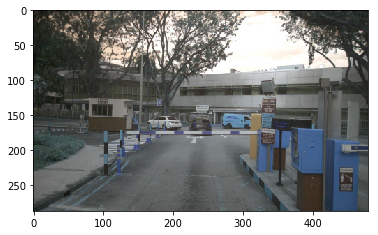

In [79]:
plt.imshow(cv2.resize(img_data, (480, 288)))

---
## redistribute train and val correctly

In [98]:
a = (1,2,3)

In [99]:
a[0] = 3

TypeError: 'tuple' object does not support item assignment

In [73]:
import os
import shutil
train_imgs = [x for x in os.listdir("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/train") if x[-1] == 'g']
val_imgs = [x for x in os.listdir("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/val") if x[-1] == 'g']

In [73]:
# # train_imgs = [x for x in os.listdir("../nuscene_darknet/train") if x[-1] == 'g']
# # val_imgs = [x for x in os.listdir("../nuscene_darknet/val") if x[-1] == 'g']

# files_to_move = sorted(train_imgs)[43503:]

# from tqdm import tqdm
# for f in tqdm(files_to_move):
#     imgname = f
#     lblname = f[:-3]+'txt'
#     shutil.move("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/train/"+imgname, "/media/sf/61CEC7C06EDB83CC/nuscene_darknet/val/"+imgname)
#     shutil.move("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/train/"+lblname, "/media/sf/61CEC7C06EDB83CC/nuscene_darknet/val/"+lblname)

## create train image and val image lists

In [74]:
train_imgs = [x for x in os.listdir("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/train") if x[-1] == 'g']

In [86]:
import random
random.seed(1)
train_list = ["/media/sf/61CEC7C06EDB83CC/nuscene_darknet/train/" + x for x in train_imgs]
random.shuffle(train_list)

In [88]:
with open('/home/sf/darknet/data/nuscenes/train.txt','w') as f:
    f.writelines([x+'\n' for x in train_list])

---

In [90]:
val_imgs = [x for x in os.listdir("/media/sf/61CEC7C06EDB83CC/nuscene_darknet/val") if x[-1] == 'g']

In [95]:
import random
random.seed(1)
val_list = ["/media/sf/61CEC7C06EDB83CC/nuscene_darknet/val/" + x for x in val_imgs]
random.shuffle(val_list)

In [97]:
with open('/home/sf/darknet/data/nuscenes/val.txt','w') as f:
    f.writelines([x+'\n' for x in val_list])